In [1]:
import glob
import json


import geopandas as gpd
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
from shapely.geometry import Point

from datetime import datetime


In [2]:
START = (38.900192, -77.042114)
END = (38.900189, -77.031378)
start_gdf = gpd.GeoDataFrame({"geometry": gpd.GeoSeries([Point(START[::-1]),
                                                         Point(END[::-1])])})
start_gdf.crs = {"init": "epsg:4326"}
start_gdf = start_gdf.to_crs(epsg=3857)
BUSES = ["30N", "30S", "32", "33", "36"]
start_gdf.head()

I am densified (external_values, 2 elements)
I am densified (2 elements)
I am densified (2 elements)


,geometry
0,POINT (-8576288.900117334 4707384.999884105)
1,POINT (-8575093.774064178 4707384.570764533)


In [3]:

def process_json(fname):
    with open(fname) as f:
        data = json.load(f)
        if set(data.keys()) != set(['BusPositions']):
            raise Exception("Other keys? {}".format(set(data.keys())))
        return data['BusPositions']
    
def load_day(day):
    df = pd.concat((pd.DataFrame(process_json(x)) for x in  glob.glob("data/"+day +"/*")), ignore_index=True)
    garr = gpd.vectorized.points_from_xy(df["Lon"].as_matrix(), df["Lat"].as_matrix())
    df["geometry"] = garr
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init' :'epsg:4326'}
    gdf = gdf.to_crs(epsg=3857)
    gdf["dt"] = pd.to_datetime(gdf["DateTime"])
    return gdf

gtfs_trips = pd.read_csv("data/gtfs/trips.txt", dtype={'trip_id': str, 'scheduled_trip_id': str})
gtfs_schedule = pd.read_csv("data/gtfs/stop_times.txt", dtype={'trip_id': str})
gtfs_cal = pd.read_csv("data/gtfs/calendar_dates.txt")
gtfs_stops = pd.read_csv("data/gtfs/stops.txt", dtype={'trip_id': str, 'scheduled_trip_id': str})

gdf = load_day("2019-05-15")

I am densified (external_values, 673545 elements)


In [4]:
gtfs_stops["geometry"] = gtfs_stops[["stop_lon", "stop_lat"]].apply(Point, axis=1)
stops_gdf = gpd.GeoDataFrame(gtfs_stops)

stops_gdf.head()

I am densified (5 elements)
I am densified (5 elements)


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,geometry
0,1,1002500,WISCONSIN AVE NW & RIVER RD NW,NaN,38.949019,-77.080369,8,POINT (-77.08036899999999 38.949019)
1,3,3002395,9TH ST & RAILROAD AVE,NaN,39.008222,-76.780363,8,POINT (-76.78036299999999 39.008222)
2,9,3002207,14TH AVE & LANGLEY WAY,NaN,38.990257,-76.984353,5,POINT (-76.984353 38.990257)
3,10,3002213,14TH AVE & LANGLEY WAY,NaN,38.990479,-76.984519,5,POINT (-76.98451899999999 38.990479)
4,11,3002191,KANAWHA ST & 14TH AVE,NaN,38.988320,-76.983581,5,POINT (-76.983581 38.98832)


In [5]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

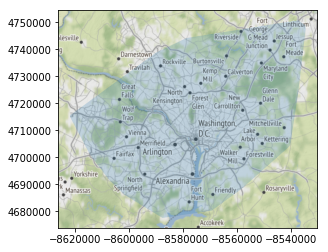

In [6]:
ax = gpd.GeoSeries([gdf.geometry.unary_union.convex_hull]).plot(alpha=.2)
add_basemap(ax, 10)

In [7]:
gdf["dt"] = pd.to_datetime(gdf["DateTime"])
gdf = gdf.sort_values("dt")
gdf.head()

I am densified (5 elements)
I am densified (5 elements)


,BlockNumber,DateTime,Deviation,DirectionNum,DirectionText,Lat,Lon,RouteID,TripEndTime,TripHeadsign,TripID,TripStartTime,VehicleID,geometry,dt
118756,M-704,2019-05-14T19:36:14,-5.0,1,SOUTH,38.905659,-77.022011,70,2019-05-14T19:54:00,ARCHIVES,898790020,2019-05-14T18:48:00,5448,POINT (-8574051.044393916 4708167.028910984),2019-05-14 19:36:14
472654,M-704,2019-05-14T19:36:14,-5.0,1,SOUTH,38.905659,-77.022011,70,2019-05-14T19:54:00,ARCHIVES,898790020,2019-05-14T18:48:00,5448,POINT (-8574051.044393916 4708167.028910984),2019-05-14 19:36:14
152317,M-704,2019-05-14T19:36:14,-5.0,1,SOUTH,38.905659,-77.022011,70,2019-05-14T19:54:00,ARCHIVES,898790020,2019-05-14T18:48:00,5448,POINT (-8574051.044393916 4708167.028910984),2019-05-14 19:36:14
6213,M-704,2019-05-14T19:36:14,-5.0,1,SOUTH,38.905659,-77.022011,70,2019-05-14T19:54:00,ARCHIVES,898790020,2019-05-14T18:48:00,5448,POINT (-8574051.044393916 4708167.028910984),2019-05-14 19:36:14
573481,M-704,2019-05-14T19:36:14,-5.0,1,SOUTH,38.905659,-77.022011,70,2019-05-14T19:54:00,ARCHIVES,898790020,2019-05-14T18:48:00,5448,POINT (-8574051.044393916 4708167.028910984),2019-05-14 19:36:14


In [8]:
interesting = gdf[gdf["RouteID"].isin(BUSES)]

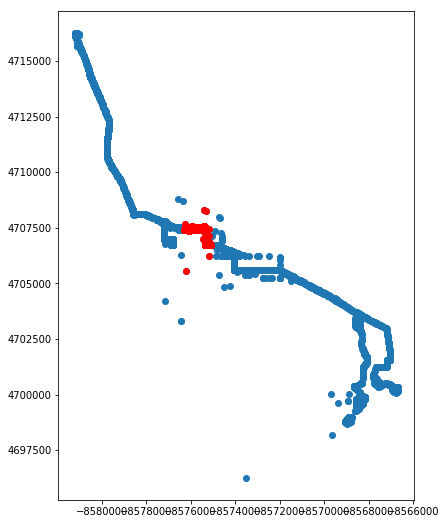

In [9]:
samp = interesting.sample(5000)
ax = samp.plot(figsize=(16, 9))
q = samp[(samp.geometry.x > start_gdf.loc[0].x) & (samp.geometry.x < start_gdf.loc[1].x)]
q.plot(ax=ax, color='red')

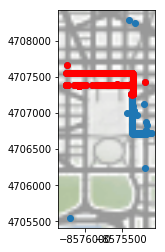

In [11]:
ax = q.plot()
q2 = q[(q.geometry.y > 4707250) & (q.geometry.y < 4707750)]
ax = q2.plot(ax=ax, color='red')

add_basemap(ax, 12)

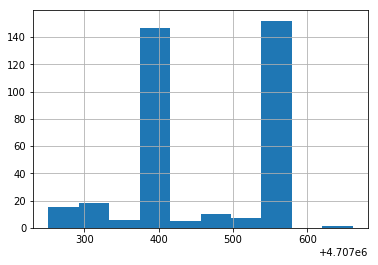

In [12]:
q2.geometry.y.hist()

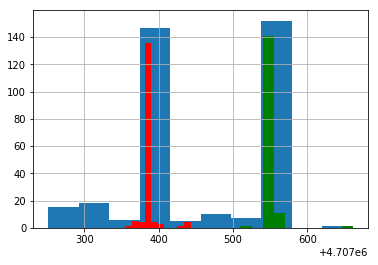

In [18]:
h_street = q2[(q2.geometry.y > 4707350) & (q2.geometry.y < 4707450)]
i_street = q2[(q2.geometry.y > 4707510)]

ax = q2.geometry.y.hist()
h_street.geometry.y.hist(color='red', ax=ax)
i_street.geometry.y.hist(color='green', ax=ax)

### The above does not work because we only get maybe 1 GPS read on H/I street proper. So let's pull out the readings before/after the street itself

In [109]:
def h_street_filter(g):
    filt1 = g[(g.geometry.y > 4707350) & (g.geometry.y < 4707450)\
              & (g.geometry.x > start_gdf.loc[0].x) & (g.geometry.x < start_gdf.loc[1].x)]
    if np.abs(filt1.geometry.x.min() - filt1.geometry.x.max()) > 400:
        return filt1
    else:
        return []

def i_street_filter(g):
    filt1 = g[(g.geometry.y > 4707510) & (g.geometry.y < 4707600)\
              & (g.geometry.x > start_gdf.loc[0].x) & (g.geometry.x < start_gdf.loc[1].x)]
    if np.abs(filt1.geometry.x.min() - filt1.geometry.x.max()) > 400:
        return filt1
    else:
        return []

bad_ids = []
def process_trip(g):
    h_street_records = h_street_filter(g)
    i_street_records = i_street_filter(g)
    if len(h_street_records) > 0 and len(i_street_records) > 0:
        bad_ids.append(g.name)
        return (None)
    if len(h_street_records) == 0 and len(i_street_records) == 0:
        bad_ids.append(g.name)
        return (None)
    retval = ('h', h_street_records) if len(h_street_records) > 0 else ('i', i_street_records)
    retval[1]["corridor"] = retval[0]
    return retval[1].reset_index()
        
results = interesting.groupby("TripID").apply(process_trip)

In [133]:
FEET_PER_METER = 3.28084
def segment_speed(g):
    if len(g) < 3:
        return -1
    start_ix, end_ix = g["dt"].idxmin(), g["dt"].idxmax()
    dist = (FEET_PER_METER * g.loc[start_ix]["geometry"].distance(g.loc[end_ix]["geometry"]))
    time = g.loc[end_ix]["dt"] - g.loc[start_ix]["dt"]
    return (dist, time.total_seconds(), dist / time.total_seconds(),
            g["corridor"].unique()[0], len(g), g.loc[start_ix]["dt"], g.loc[end_ix]["dt"])
rst = results.reset_index(level=1)
del rst["level_1"]
x = rst.reset_index(drop=True).groupby("TripID").apply(segment_speed).apply(pd.Series).reset_index()
x.columns = ['TripID', 'distance', 'time', 'rate', 'corridor', 'n', 'start_t', 'end_t']

,TripID,distance,time,rate,corridor,n,start_t,end_t
0,898277020,-1.000000,NaN,NaN,NaN,NaN,NaT,NaT
1,898278020,-1.000000,NaN,NaN,NaN,NaN,NaT,NaT
2,898279020,2998.103117,185.0,16.205963,i,4.0,2019-05-15 05:45:43,2019-05-15 05:48:48
3,898280020,1811.766763,110.0,16.470607,i,3.0,2019-05-15 04:35:48,2019-05-15 04:37:38
4,898281020,1713.652982,133.0,12.884609,i,3.0,2019-05-15 05:24:34,2019-05-15 05:26:47


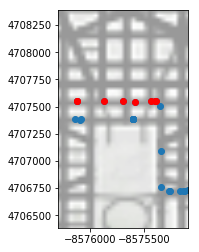

In [75]:
# code to check out weird results from processing
ax = interesting[interesting.TripID == '940875020'].plot()
add_basemap(ax, 12)
ax.set_xlim([start_gdf.loc[0].x, start_gdf.loc[1].x])
ax.set_ylim([start_gdf.loc[0].y - 1000, start_gdf.loc[0].y + 1000])

one_trip = interesting[(interesting.TripID == '940875020')]
i_street_filter(one_trip).plot(ax=ax, color='red')

In [138]:
results.head()

I am densified (5 elements)
I am densified (5 elements)


index BlockNumber             DateTime  Deviation  DirectionNum  \
TripID                                                                          
898277020 0  201798       W-312  2019-05-15T03:00:42       -2.0             1   
          1  330522       W-312  2019-05-15T03:01:45       -1.0             1   
898278020 0   34218       W-311  2019-05-15T02:39:23        7.0             1   
          1  386639       W-311  2019-05-15T02:40:41        8.0             1   
898279020 0  132315       W-303  2019-05-15T05:45:43        0.0             1   

            DirectionText        Lat        Lon RouteID          TripEndTime  \
TripID                                                                         
898277020 0          WEST  38.901394 -77.034264     30N  2019-05-15T03:25:00   
          1          WEST  38.901333 -77.038010     30N  2019-05-15T03:25:00   
898278020 0          WEST  38.901367 -77.034264     30S  2019-05-15T02:55:00   
          1          WEST  38.901348 -77.039215     30S  2019-05-15T02:55:00   
898279020 0          WEST  38.901337 -77.033798     30S  2019-05-15T06:19:00   

                   TripHeadsign     TripID        TripStartTime VehicleID  \
TripID                                                                      
898277020 0  FRIENDSHIP HEIGHTS  898277020  2019-05-15T02:30:00      7154   
          1  FRIENDSHIP HEIGHTS  898277020  2019-05-15T02:30:00      7154   
898278020 0  FRIENDSHIP HEIGHTS  898278020  2019-05-15T02:00:00      7125   
          1  FRIENDSHIP HEIGHTS  898278020  2019-05-15T02:00:00      7125   
898279020 0  FRIENDSHIP HEIGHTS  898279020  2019-05-15T05:05:00      7154   

                                                 geometry                  dt  \
TripID                                                                          
898277020 0  POINT (-8575415.042114604 4707556.935252312) 2019-05-15 03:00:42   
          1  POINT (-8575832.044927116 4707548.209676828) 2019-05-15 03:01:45   
898278020 0   POINT (-8575415.042114604 4707553.07311142) 2019-05-15 02:39:23   
          1   POINT (-8575966.184913523 4707550.35530945) 2019-05-15 02:40:41   
898279020 0  POINT (-8575363.167231897 4707548.781845481) 2019-05-15 05:45:43   

            corridor  
TripID                
898277020 0        i  
          1        i  
898278020 0        i  
          1        i  
898279020 0        i